In [1]:
import math
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, GaussianBlur
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as TF

# MedMNIST import
import medmnist
from medmnist import INFO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- MedMNIST Data setup ---
data_flag = 'chestmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
# Download datasets
train_dataset = DataClass(split='train', download=True)
# test_dataset  = DataClass(split='test' , download=True)   

# Train / test
numSamples = int(0.8 * len(train_dataset))
# numTest    = len(test_dataset)                          

Using device: cuda
Using downloaded and verified file: C:\Users\alexr\.medmnist\chestmnist.npz


In [10]:
# Prepare data tensors --------------------------------------------------------
def _get_tensor(ds, n):
    """Stack first n samples, convert to float32 in [0,1]."""
    imgs = []
    for i in range(n):
        x, _ = ds[i]
        if isinstance(x, torch.Tensor):
            t = x.float() / 255.0
        elif isinstance(x, np.ndarray):
            t = torch.from_numpy(x).float() / 255.0
            if t.ndim == 3:
                t = t.permute(2, 0, 1)
        else:
            t = TF.to_tensor(x)
        imgs.append(t[0])
    return torch.stack(imgs).to(device)

X_raw = _get_tensor(train_dataset, numSamples)  # (N, H, W)
# X_raw_test  = _get_tensor(test_dataset , numTest)  # COMMENTED OUT

dim = X_raw[0].numel()  # 28*28 = 784
r = 25  # bottleneck / testing rank

# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# X (clean) using torch.cov

X = X_raw.view(numSamples, -1).T
#X = X - X.mean(dim=0, keepdim=True)
#gammaX = torch.cov(X.T, correction=1)
gammaX = (1/numSamples) * X @ X.T
#gammaX += 1e-5 * torch.eye(dim, device=device)
L_X = torch.linalg.cholesky(gammaX)


# Condition number of gammaX
cond_gammaX = torch.linalg.cond(gammaX)
print(f"Condition number of gammaX: {cond_gammaX:.2e}")

# F matrix (blur)
blurKernelSizeF = 5
#blurSigmaF = 1.5
blurSigmaF = 1.0
forwardBlur = GaussianBlur(kernel_size=blurKernelSizeF, sigma=blurSigmaF)
basisImages = torch.eye(dim).reshape(dim, 1, 28, 28)
F_cols = []
for j in range(dim):
    F_cols.append(forwardBlur(basisImages[j]).flatten())
F = torch.stack(F_cols, dim=1).to(device)
FX = F @ X

# Condition number of F
cond_F = torch.linalg.cond(F)
print(f"Condition number of F: {cond_F:.2e}")

# Y = F(X) + noise
noiseSigma = 0.05
E = torch.randn_like(FX) * noiseSigma
Y = FX + E
muY = Y.mean(dim=1, keepdim=True)
#Y = Y - muY
print(f"Noise sigma: {noiseSigma:.2e}")


# gammaY and gammaE
gammaE = noiseSigma**2 * torch.eye(dim, device=device)
gammaY = F @ gammaX @ F.T + gammaE #+ 1e-5 * torch.eye(dim, device=device)
L_Y = torch.linalg.cholesky(gammaY)

# Condition number of gammaY
cond_gammaY = torch.linalg.cond(gammaY)
print(f"Condition number of gammaY: {cond_gammaY:.2e}")

# Theoretical best M_r via SVD
M  = gammaX @ F.T @ torch.linalg.inv(gammaY)
U, S, Vh = torch.linalg.svd(M)

# Condition number of M
cond_M = torch.linalg.cond(M)
print(f"Condition number of M: {cond_M:.2e}")

U_r, S_r, Vh_r = U[:, :r], torch.diag(S[:r]), Vh[:r, :]
M_r = U_r @ S_r @ Vh_r

# Condition number of M_r
cond_M_r = torch.linalg.cond(M_r)
print(f"Condition number of M_r (rank-{r} truncation): {cond_M_r:.2e}")

# Theoretical error: average per-sample l2 discrepancy ------------------------
diffs_opt = M_r @ Y - X
rel_error_theory_train = torch.norm(diffs_opt, dim=0).mean().item()  # average over samples

print(f"Theoretical average per-sample L2 training error: {rel_error_theory_train:.4f}")


Condition number of gammaX: 1.10e+08
Condition number of F: 1.92e+03
Noise sigma: 5.00e-02
Condition number of gammaY: 8.86e+04
Condition number of M: 2.90e+07
Condition number of M_r (rank-25 truncation): 4.80e+11
Theoretical average per-sample L2 training error: 14.9090


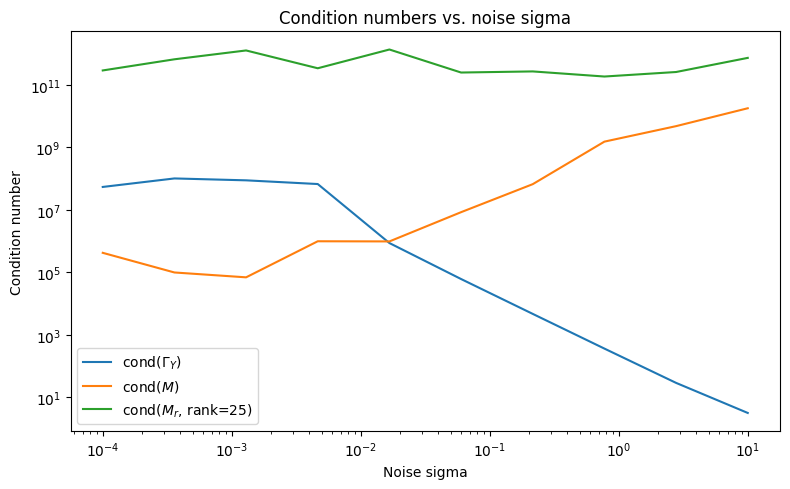

In [11]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot condition numbers vs. noise sigma
# ─────────────────────────────────────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt

r = 25
# Define range of noise sigma values to test
noiseSigmas = np.logspace(-4, 1, 10)  

# Initialize storage
cond_gammaX_list = []
cond_F_list = []
cond_gammaY_list = []
cond_M_list = []
cond_M_r_list = []

# Sweep over noiseSigmas
for ns in noiseSigmas:
    # Recompute gammaE, gammaY, M, M_r at each noise sigma

    gammaE = ns**2 * torch.eye(dim, device=device)
    gammaY = F @ gammaX @ F.T + gammaE + 1e-5 * torch.eye(dim, device=device)

    M  = gammaX @ F.T @ torch.linalg.inv(gammaY)
    U, S, Vh = torch.linalg.svd(M)
    U_r, S_r, Vh_r = U[:, :r], torch.diag(S[:r]), Vh[:r, :]
    M_r = U_r @ S_r @ Vh_r

    # Record condition numbers
    cond_gammaX_list.append(torch.linalg.cond(gammaX).cpu().item())
    cond_F_list.append(torch.linalg.cond(F).cpu().item())
    cond_gammaY_list.append(torch.linalg.cond(gammaY).cpu().item())
    cond_M_list.append(torch.linalg.cond(M).cpu().item())
    cond_M_r_list.append(torch.linalg.cond(M_r).cpu().item())

# Plotting
plt.figure(figsize=(8,5))

#plt.plot(noiseSigmas, cond_gammaX_list, label=r'cond($\Gamma_X$)')
#plt.plot(noiseSigmas, cond_F_list, label=r'cond($F$)')
plt.plot(noiseSigmas, cond_gammaY_list, label=r'cond($\Gamma_Y$)')
plt.plot(noiseSigmas, cond_M_list, label=r'cond($M$)')
plt.plot(noiseSigmas, cond_M_r_list, label=fr'cond($M_r$, rank={r})')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Noise sigma')
plt.ylabel('Condition number')
plt.title('Condition numbers vs. noise sigma')
plt.legend()
plt.tight_layout()
plt.show()


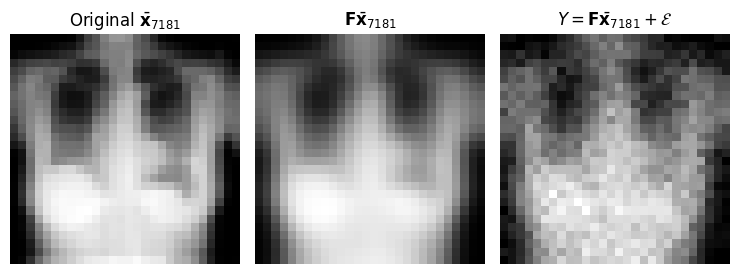

In [12]:
# ── quick 1×3 preview: (\bar{X}, F \bar{X}, F \bar{X} + E) ─────────────────────
import os
import matplotlib.pyplot as plt

# random training-set index
#idx = np.random.randint(0, numSamples)
idx = 7181

# (i) original image  →  (H,W)
orig_img = X_raw[idx].cpu()          # already in [0,1]
if orig_img.ndim == 3:               # safety: drop channel dim
    orig_img = orig_img[0]

# (ii) blurred image  F \bar{X}
blur_img = forwardBlur(orig_img.unsqueeze(0)).squeeze(0).cpu()

# (iii) blurred + noise image  F \bar{X} + E
noise            = torch.randn_like(blur_img) * noiseSigma
blur_noise_img   = (blur_img + noise).clamp(0, 1).cpu()

# ── plot & save ──────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.7))
axes[0].imshow(orig_img,        cmap='gray')
axes[0].set_title(r'Original $\bar{\mathbf{x}}_{7181}$')
axes[0].axis('off')

axes[1].imshow(blur_img,        cmap='gray')
axes[1].set_title(r'$\mathbf{F} \bar{\mathbf{x}}_{7181}$')
axes[1].axis('off')

axes[2].imshow(blur_noise_img,  cmap='gray')
axes[2].set_title(r'$Y = \mathbf{F} \bar{\mathbf{x}}_{7181} + \mathcal{E}$')
axes[2].axis('off')

plt.tight_layout()

out_dir = f"end2endpics/MedMNIST"
os.makedirs(out_dir, exist_ok=True)
#plt.savefig(f"{out_dir}/{data_flag}_mapping{idx}_{r}.png", dpi=300)
plt.show()


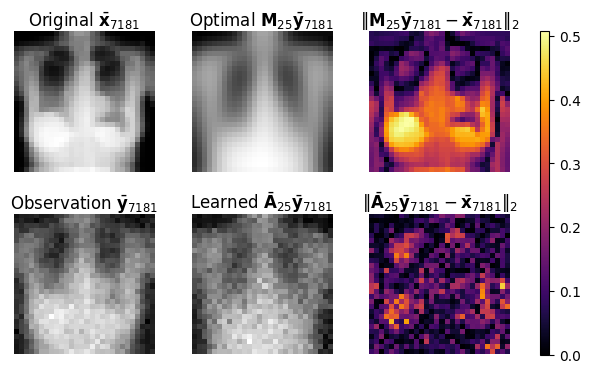

In [14]:
# --- Autoencoder setup -------------------------------------------------------
batch_size = 128
num_epochs = 350

X_tensor = X.clone().to(torch.float32)
Y_tensor = Y.clone().to(torch.float32)

class LinearAutoencoder(nn.Module):
    def __init__(self, input_dim, bottleneck_dim):
        super().__init__()
        self.encoder = nn.Linear(input_dim, bottleneck_dim, bias=False)
        self.decoder = nn.Linear(bottleneck_dim, input_dim, bias=False)
    def forward(self, x):
        return self.decoder(self.encoder(x))

model     = LinearAutoencoder(input_dim=dim, bottleneck_dim=r).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training loop using average per-sample L2 error -----------------------------
train_errors = []
for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()

    outputs = model(Y.T)
    target  = X.T

    loss = criterion(outputs, target)
    loss.backward()
    optimizer.step()

    # Evaluate and store error after each epoch
    with torch.no_grad():
        A_learned = model.decoder.weight @ model.encoder.weight

        diffs = A_learned @ Y - X
        avg_l2_err = torch.norm(diffs, dim=0).mean().item()  # average per-sample l2 discrepancy

        train_errors.append(avg_l2_err)

# Plot convergence vs. theoretical optimum ------------------------------------
#plt.figure(figsize=(6, 4))
#plt.plot(range(1, num_epochs+1), train_errors, label='Training', #color='#a7c080')
#plt.axhline(rel_error_theory_train, ls='--', color='k', label='Optimal')
#plt.xlabel('Epoch')
#plt.ylabel(r'Average $\ell_2$ Reconstruction Error')
#plt.title(f'Encoder-Decoder vs. Bayes-optimal ({data_flag})')
#plt.legend()
#plt.tight_layout()
#plt.show()

# --- Compact 2×3 gallery with Everforest colormap ----------------------------
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap

everforest_colors = [
    "#2d353b", "#3d484d", "#4f585e", "#566358", "#5a6f47",
    "#7a9c58", "#a7c080", "#dbbc7f", "#e69875", "#e67e80", "#dc5456"
]

everforest_cmap = LinearSegmentedColormap.from_list(
    'everforest_blend',
    everforest_colors,
    N=256
)

for _ in range(1):
    idx = 7181

    orig_img   = X_raw[idx].view(28, 28).cpu()
    y_img      = Y[:, idx].view(28, 28).cpu()
    opt_img    = (M_r @ Y)[:, idx].view(28, 28).cpu()
    learn_img  = (A_learned @ Y)[:, idx].view(28, 28).cpu()

    err_opt   = torch.abs(opt_img   - orig_img)
    err_learn = torch.abs(learn_img - orig_img)
    err_vmin, err_vmax = 0.0, max(err_opt.max(), err_learn.max()).item()

    fig = plt.figure(figsize=(7, 4.2))
    gs  = gridspec.GridSpec(
        2, 4,
        width_ratios=[1, 1, 1, 0.06],
        wspace=0.20, hspace=0.30
    )

    # row 0
    ax = fig.add_subplot(gs[0, 0])
    ax.imshow(orig_img, cmap='gray')
    ax.set_title(r'Original $\bar{\mathbf{x}}_{7181}$', pad=4)
    ax.axis('off')

    ax = fig.add_subplot(gs[0, 1])
    ax.imshow(opt_img, cmap='gray')
    ax.set_title(r'Optimal $\mathbf{M}_{25} \bar{\mathbf{y}}_{7181}$', pad=4)
    ax.axis('off')

    ax = fig.add_subplot(gs[0, 2])
    im = ax.imshow(err_opt, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
    ax.set_title(r'$\|\mathbf{M}_{25} \bar{\mathbf{y}}_{7181} - \bar{\mathbf{x}}_{7181}\|_2$', pad=4)
    ax.axis('off')

    # row 1
    ax = fig.add_subplot(gs[1, 0])
    ax.imshow(y_img, cmap='gray')
    ax.set_title(r'Observation $\bar{\mathbf{y}}_{7181}$', pad=4)
    ax.axis('off')

    ax = fig.add_subplot(gs[1, 1])
    ax.imshow(learn_img, cmap='gray')
    ax.set_title(r'Learned $\bar{\mathbf{A}}_{25} \bar{\mathbf{y}}_{7181}$', pad=4)
    ax.axis('off')

    ax = fig.add_subplot(gs[1, 2])
    ax.imshow(err_learn, cmap='inferno', vmin=err_vmin, vmax=err_vmax)
    ax.set_title(r'$\|\bar{\mathbf{A}}_{25} \bar{\mathbf{y}}_{7181} - \bar{\mathbf{x}}_{7181}\|_2$', pad=4)
    ax.axis('off')

    # color-bar
    cax = fig.add_subplot(gs[:, 3])
    plt.colorbar(im, cax=cax)
    cax.yaxis.tick_right()
    #plt.savefig(f"end2endpics\MedMNIST\chestmnist\sample{idx}_{numSamples}_{r}.png")
    plt.show()


In [19]:
# ════════════════════════════════════════════════════════════════════════════
# MULTI-DATASET RANK SWEEP  (chestmnist, organamnist, organcmnist,
#                            organsmnist, retinamnist)
#   • Saves Bayes–optimal map  M_r
#   • Saves learned encoder / decoder weight matrices
#   • One pickle per (dataset, rank):
#       {"optimalMatrix":  M_r,
#        "encoderWeight":  W_enc,
#        "decoderWeight":  W_dec}
# ════════════════════════════════════════════════════════════════════════════
import os, pickle, torch
from collections import defaultdict
from copy import deepcopy
from torchvision.transforms import GaussianBlur
import matplotlib.pyplot as plt

# ── pastel-Everforest colours ───────────────────────────────────────────────
ef_pastel   = ['#a7c080', '#d3869b', "#83c0c0", '#e69875', '#a988b0', "#b8912f"]
line_styles = {'theory': '-',  'learned': '--'}
markers     = {'theory': 'o',  'learned': 's'}
lw, ms      = 1.5, 4

# ── where to stash matrices and final plots ─────────────────────────────────
save_root     = "E2EInvPics"
matrices_root = os.path.join(save_root, "MedMNIST", "Matrices")
tests_root    = os.path.join(save_root, "MedMNIST", "Tests")
os.makedirs(matrices_root, exist_ok=True)
os.makedirs(tests_root, exist_ok=True)

# ── helper: run rank sweep on ONE MedMNIST subset ───────────────────────────
def run_rank_sweep(data_flag, ranks, train_epochs=350, lr=1e-3):
    """Return ([theory avg l2], [AE avg l2]) for the given dataset
       and store matrices to pickles for every rank."""
    info        = INFO[data_flag]
    DataClass   = getattr(medmnist, info['python_class'])
    train_ds    = DataClass(split='train', download=True)

    numSamples  = int(0.8 * len(train_ds))
    X_raw       = _get_tensor(train_ds, numSamples)
    dim         = X_raw[0].numel()

    # --- build centred X, Y -------------------------------------
    X   = X_raw.view(numSamples, -1).T
    #muX = X.mean(dim=1, keepdim=True)
    #X   = X - muX
    gammaX  = (X @ X.T)/(numSamples)

    blurKernelSizeF = 5
    blurSigmaF = 1.0
    blur   = GaussianBlur(kernel_size=blurKernelSizeF, sigma=blurSigmaF)
    basisImages  = torch.eye(dim).reshape(dim, 1, 28, 28)
    F_cols  = [blur(basisImages[j]).flatten() for j in range(dim)]
    F      = torch.stack(F_cols, dim=1).to(device)

    FX = F @ X
    noiseSigma  = 0.05
    Y  = FX + torch.randn_like(FX)*noiseSigma
    muY = Y.mean(dim=1, keepdim=True)
    Y  = Y - muY

    gammaE = noiseSigma**2 * torch.eye(dim, device=device)
    gammaY = F @ gammaX @ F.T + gammaE
    M  = gammaX @ F.T @ torch.linalg.inv(gammaY)
    U, S, Vh = torch.linalg.svd(M)

    # losses
    theory_err, learned_err = [], []
    ds_dir = os.path.join(matrices_root, data_flag)
    os.makedirs(ds_dir, exist_ok=True)

    for r in ranks:
        if r % 100 == 0:
            print(f"On Rank {r}")
        # --- Bayes-optimal map (truncated SVD) ------------------------------
        U_r, S_r, Vh_r = U[:, :r], torch.diag(S[:r]), Vh[:r, :]
        M_r = U_r @ S_r @ Vh_r
        diffs_opt   = M_r @ Y - X
        avg_l2_opt  = torch.norm(diffs_opt, dim=0).mean().item()
        theory_err.append(avg_l2_opt)

        # --- linear autoencoder of rank r -----------------------------------
        ae   = LinearAutoencoder(dim, r).to(device)
        opt  = optim.Adam(ae.parameters(), lr=lr)
        for _ in range(train_epochs):
            opt.zero_grad()
            out  = ae(Y.T)
            loss = criterion(out, X.T)
            loss.backward()
            opt.step()

        with torch.no_grad():
            W_enc = ae.encoder.weight.detach().cpu()
            W_dec = ae.decoder.weight.detach().cpu()
            A     = W_dec @ W_enc            # learned full map
            diffs_learn  = A.to(device) @ Y - X
            avg_l2_learn = torch.norm(diffs_learn, dim=0).mean().item()
        learned_err.append(avg_l2_learn)

        # --- save matrices --------------------------------------------------
        #dump_path = os.path.join(ds_dir, f"rank_{r:03d}.pkl")
        #with open(dump_path, "wb") as f:
        #    pickle.dump(
        #        {
        #            "optimalMatrix": M_r.cpu(),
        #            "encoderWeight": W_enc,
        #            "decoderWeight": W_dec,
        #        },
        #        f,
        #        protocol=pickle.HIGHEST_PROTOCOL,
        #    )

    return theory_err, learned_err

# ── run all requested datasets ──────────────────────────────────────────────
#datasets  = ['breastmnist', 'chestmnist', 'organamnist', 'organcmnist', 'organsmnist', 'retinamnist']
datasets = ['organsmnist', 'retinamnist', 'chestmnist']
ranks     = list(range(25, 776, 25))
results   = defaultdict(dict)

for flag in datasets:
    print(f"\n▶ Running rank sweep for {flag} …")
    th, le = run_rank_sweep(flag, ranks, train_epochs=350)
    results[flag]['theory']  = th
    results[flag]['learned'] = le



▶ Running rank sweep for organsmnist …
Using downloaded and verified file: C:\Users\alexr\.medmnist\organsmnist.npz
On Rank 100
On Rank 200
On Rank 300
On Rank 400
On Rank 500
On Rank 600
On Rank 700

▶ Running rank sweep for retinamnist …
Using downloaded and verified file: C:\Users\alexr\.medmnist\retinamnist.npz
On Rank 100
On Rank 200
On Rank 300
On Rank 400
On Rank 500
On Rank 600
On Rank 700

▶ Running rank sweep for chestmnist …
Using downloaded and verified file: C:\Users\alexr\.medmnist\chestmnist.npz
On Rank 100
On Rank 200
On Rank 300
On Rank 400
On Rank 500
On Rank 600
On Rank 700


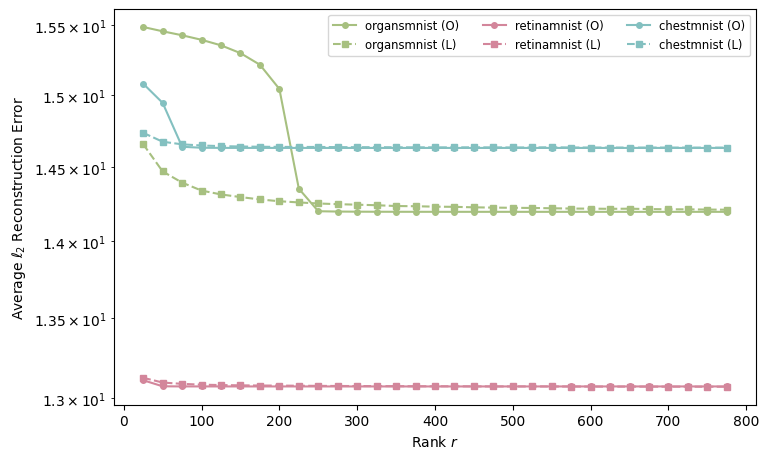

In [20]:
# ── combined plot ───────────────────────────────────────────────────────────
plt.figure(figsize=(7.8, 4.7))
short_label = {'theory': 'O', 'learned': 'L'}

for i, flag in enumerate(datasets):
    col = ef_pastel[i % len(ef_pastel)]
    for kind in ('theory', 'learned'):
        plt.plot(ranks,
                 results[flag][kind],
                 line_styles[kind],
                 marker=markers[kind],
                 color=col,
                 lw=lw,
                 ms=ms, 
                 label=f"{flag} ({short_label[kind]})")

plt.xlabel('Rank $r$')
plt.ylabel(r'Average $\ell_2$ Reconstruction Error')
plt.yscale('log')
#plt.title('Average $\ell_2$ Error vs. Rank')
plt.legend(ncol=3, fontsize='small')
plt.tight_layout()
#plt.savefig("end2endpics/MedMNIST/Tests/medmnist_rank_sweep_avg_2000_epoch.png")
plt.show()

In [8]:
# ── Inspect stored matrices & compare singular values (4 decimals) ─────────
#    • Lists datasets / ranks, loads each pickle
#    • Computes singular values of
#        – Bayes–optimal map  Mr
#        – Learned map        A = W_dec @ W_enc
#    • Prints top-k singular values (rounded to 4 decimals) and relative ℓ2 error

import os, pickle, torch

base_dir  = "end2endpics/MedMNIST/Matrices"
top_k     = 10                              # how many singular values to show
torch.set_printoptions(edgeitems=3, linewidth=120, sci_mode=False)

for dataset in sorted(os.listdir(base_dir)):
    ds_dir = os.path.join(base_dir, dataset)
    if not os.path.isdir(ds_dir):
        continue

    print(f"\n══════════  {dataset.upper()}  ══════════")
    for fname in sorted(fn for fn in os.listdir(ds_dir) if fn.endswith(".pkl")):
        rank   = int(fname.split("_")[1].split(".")[0])        # rank_050.pkl → 50
        fpath  = os.path.join(ds_dir, fname)

        # ── load matrices ───────────────────────────────────────────────────
        with open(fpath, "rb") as f:
            mats = pickle.load(f)

        Mr   = mats["optimalMatrix"]
        Wenc = mats["encoderWeight"]
        Wdec = mats["decoderWeight"]
        A    = Wdec @ Wenc                                    # learned full map

        # ── singular values ────────────────────────────────────────────────
        s_opt    = torch.linalg.svdvals(Mr)
        s_learn  = torch.linalg.svdvals(A)

        rel_err = torch.norm(s_opt - s_learn) / torch.norm(s_opt)

        # Round singular values to 4 decimal places for print
        s_opt_rounded   = [round(v.item(), 4) for v in s_opt[:top_k]]
        s_learn_rounded = [round(v.item(), 4) for v in s_learn[:top_k]]

        print(f"\n— Rank {rank:3d} —  ({fpath})")
        #print("optimalMatrix shape :", tuple(Mr.shape))
        #print("encoderWeight shape :", tuple(Wenc.shape))
        #print("decoderWeight shape :", tuple(Wdec.shape))
        print(f"Relative ℓ₂ error on singular values: {rel_err:.3e}")
        print(f"Top {top_k} σ(M_r):", s_opt_rounded)
        print(f"Top {top_k} σ(A)  :", s_learn_rounded)

        # Uncomment next lines if you want FULL singular value lists
        # print("\nAll σ(M_r):\n", s_opt.cpu())
        # print("\nAll σ(A):\n",   s_learn.cpu())



══════════  BREASTMNIST  ══════════

— Rank  25 —  (end2endpics/MedMNIST/Matrices\breastmnist\rank_025.pkl)
Relative ℓ₂ error on singular values: 7.675e-02
Top 10 σ(M_r): [2.3619, 2.0204, 1.9423, 1.9169, 1.8608, 1.7686, 1.761, 1.7351, 1.6925, 1.669]
Top 10 σ(A)  : [2.2723, 2.1646, 2.1338, 2.1019, 1.9942, 1.9591, 1.8909, 1.8715, 1.856, 1.8227]

— Rank  50 —  (end2endpics/MedMNIST/Matrices\breastmnist\rank_050.pkl)
Relative ℓ₂ error on singular values: 7.003e-02
Top 10 σ(M_r): [2.3619, 2.0204, 1.9423, 1.9169, 1.8608, 1.7686, 1.761, 1.7351, 1.6925, 1.669]
Top 10 σ(A)  : [2.4941, 2.1275, 2.0316, 1.9221, 1.9095, 1.8857, 1.8731, 1.8436, 1.8203, 1.7821]

— Rank  75 —  (end2endpics/MedMNIST/Matrices\breastmnist\rank_075.pkl)
Relative ℓ₂ error on singular values: 1.205e-01
Top 10 σ(M_r): [2.3619, 2.0204, 1.9423, 1.9169, 1.8608, 1.7686, 1.761, 1.7351, 1.6925, 1.669]
Top 10 σ(A)  : [2.9316, 2.2558, 2.1762, 2.0208, 1.9921, 1.9675, 1.9365, 1.9042, 1.877, 1.8573]

— Rank 100 —  (end2endpics/MedMNIS